# Clustering (apprentissage non-supervisé)

Pour de nombreux problèmes, il existe des bases de données volumineuses, mais non annotées. Dans ce cas, on souhaite souvent trouver une partition des données qui donne des groupes homogènes. Il existe de nombreux algorithmes de partitionnement de données (*clustering* en anglais) qui utilisent des critères différents d'*homogénéité* et qui, généralement, laisse le choix du nombre de groupes (appelés *clusters*) à l'utilisateur. 

L'objectif de ce TP est de se familiariser avec les principaux algorithmes de clustering, et des critères qui permettent de sélectionner le nombre de clusters (puisqu'en l'absence d'annotations, on ne peut sélectionner les hyper-paramètres par validation croisée).

Crédit : notebook inspiré d'un TP de Nicolas Enjalbert Courrech (INRAE, MIAT Toulouse).

### Notations

Soit la matrice de données $X \in \mathbb{R}^{n \times p}$ exprimant $p$ variables pour $n$ individus. Le but est de trouver une partition $C = \{C_1, \ldots, C_K\}$ des $n$ individus où $C_k \subset C$ est l'ensemble des individus du groupe $k$. On note $\mu_k \in \mathbb{R}^p$ le barycentre des individus contenus dans le groupe $k$ tels que $\forall k \in \{1, ..., K\}, \mu_k = \frac{1}{n_k} \sum_{i \in C_k} X_{i,\cdot}$ avec $n_k = |C_k|$ et $X_{i,\cdot}$ la $i$-eme ligne de la matrice $X$.

### Librairies utilisées

Dans ce TP, on utilisera les librairies `pandas` et `numpy` pour la lecture et le pré-traitement des données, `sklearn` et `scipy` pour l'implémentation et l'interprétation des algorithmes de clustering, et `matplotlib` pour la visualisation des données et des résultats.

In [1]:
import pandas as pd 
import numpy as np 

import sklearn
from sklearn import decomposition
from sklearn import cluster
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

### Préparation du jeu de données 

Nous allons utiliser les données Iris de Fisher. Notez que les annotations / variables à expliquer (*i.e.*, les espèces d'Iris) vont être utiles pour la visualisation des données et l'interprétation des résultats, mais qu'elles ne seront jamais utilisées par les algorithmes de clustering. 

In [2]:
# Credits: https://www.angela1c.com/projects/iris_project/downloading-iris/
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# using the attribute information as the column names
col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Species']
iris =  pd.read_csv(csv_url, names = col_names)
iris

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
y_true = iris[["Species"]]
y_true

,Species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [4]:
X = iris.drop(["Species"], axis = 1)
X

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [5]:
pca = decomposition.PCA(n_components = 2)
pca_X = pca.fit_transform(X)

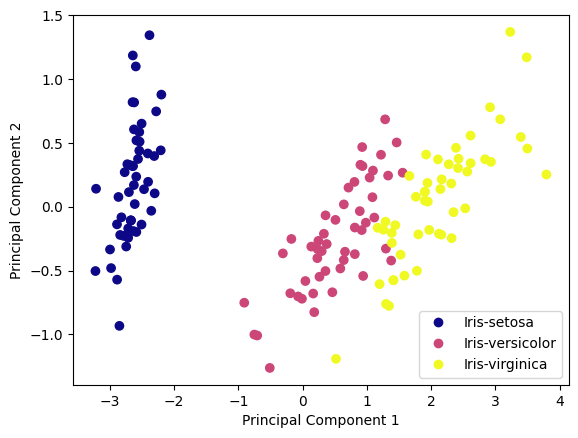

In [6]:
classes = np.unique(y_true)
str2int = dict((k, v) for (v, k) in enumerate(classes))
colors =  np.vectorize(str2int.get)(y_true)

fig, ax = plt.subplots()
scatter = plt.scatter(pca_X[:, 0], pca_X[:, 1], c=colors, cmap='plasma')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], 
           labels=list(classes))
plt.show()

## 1. Algorithmes de clustering

In [7]:
clusters = {
    'kmeans': {},
    'hier': {},
    'dbscan': {}
}

### 1.1 K-means

Utilisez la classe `sklearn.cluster.KMeans` pour catégoriser les données pour $K \in \{2, \ldots, 11\}$ clusters. Visualisez les clusters obtenus en utilisant la projection sur les deux premières composantes principales. Intuitivement, quel clustering vous semble-t-il le meilleur ? Sur quels critères vous basez vous ?

In [8]:
k_min, k_max = 2, 11
n_clustering = k_max - k_min + 1

for k in range(k_min, k_max + 1): 
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    clusters['kmeans']['k=' + str(k)] = kmeans.labels_

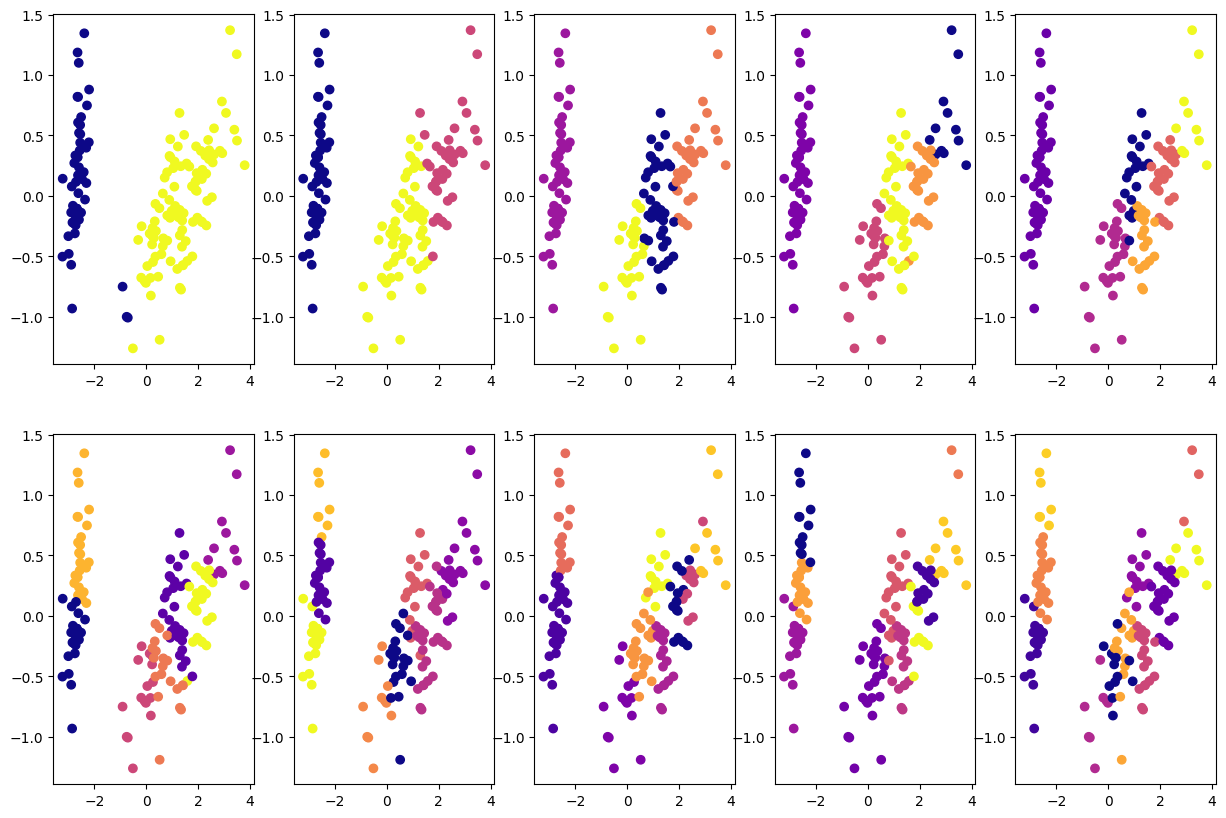

In [9]:
n_rows = 2
n_cols = n_clustering // n_rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
for i, kmeans_clusters in enumerate(clusters['kmeans'].values()):
    ax[i // n_cols, i % n_cols].scatter(pca_X[:, 0], pca_X[:, 1], c=kmeans_clusters,  cmap='plasma')
plt.show()

### 1.2 Clustering Hierarchique Ascendant

Le clustering hiérarchique ascendant est un algorithme de clustering dont le nombre de clusters diminue à chaque itération. A l'initialisation, le nombre de clusters $K$ est égal au nombre de données $n$. Ainsi, toutes les données appartiennent à des clusters différents. A chaque itération, les clusters sont fusionnés selon un critère de similarité. A l'itération $t$, il y a donc $n - t$ clusters. L'algorithme s'arrête lorsque toutes les données appartiennent à un seul cluster.

Utilisez la classe `sklearn.cluster.AgglomerativeClustering` pour catégoriser les données de manière hiérarchique avec `n_clusters=None` et `distance_threshold=0`. 

Les clusters sont centenus dans l'attribut `labels_` : sont-ils informatifs ? Recommencez en augmentant `distance_threshold`. Comment choisir cette distance ? Le choix de la distance est-il équivalent au choix du nombre de clusters ?

Utilisez à nouveau `distance_threshold=0` : que contiennent les attributs `children_` et `distances_` ? Comment évoluent les distances au cours des itérations ?

In [10]:
hier_clustering = cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=0)
hier_clustering.fit(X)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,0
,compute_distances,False


In [11]:
print(len(np.unique(hier_clustering.labels_)))

150


In [12]:
print(f"shape: {hier_clustering.children_.shape}, min value: {hier_clustering.children_.min()}, max value: {hier_clustering.children_.max()}")
hier_clustering.children_[:10, :]

shape: (149, 2), min value: 0, max value: 297


array([[  9,  34],
       [ 37, 150],
       [101, 142],
       [  7,  39],
       [  0,  17],
       [128, 132],
       [ 10,  48],
       [ 19,  21],
       [ 29,  30],
       [ 57,  93]])

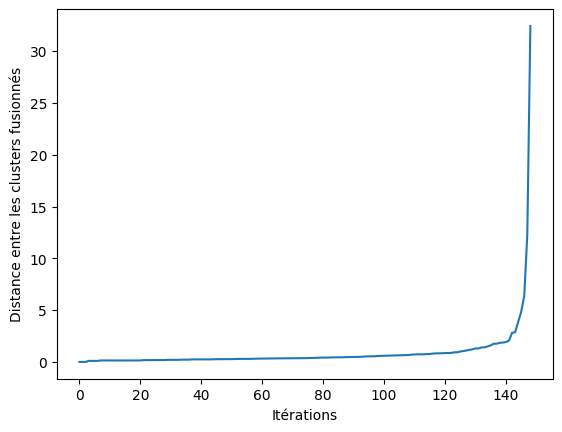

In [13]:
fig = plt.figure()
plt.plot(hier_clustering.distances_)
plt.xlabel('Itérations')
plt.ylabel('Distance entre les clusters fusionnés')
plt.show()

Un très bon outil de visualisation et d'aide à la décision est le dendogramme. Un dendogramme est un diagramme qui illustre l'arrangement des clusters. Il permet de visusaliser l'ascendance des clusters, et la distance entre les clusters fusionnés.

In [14]:
# Crédit : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

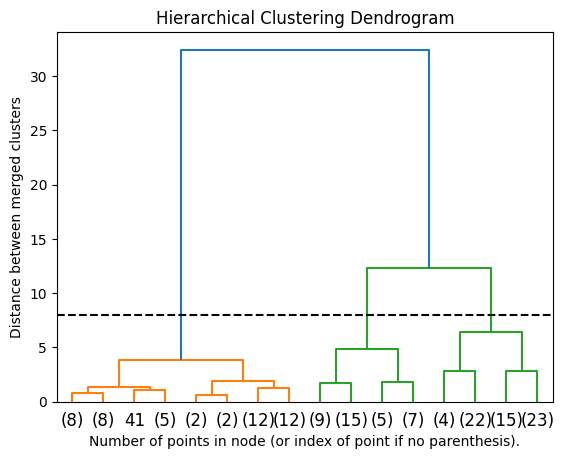

In [15]:
dist_k3 = 8

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(hier_clustering, truncate_mode="level", p=3)
plt.hlines(dist_k3, xmin=0, xmax=160, color='black', linestyle='--')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance between merged clusters")
plt.show()

Tracez sur le dendogramme la `distance_threshold` qui permet d'obtenir 3 clusters. Utilisez le clustering hiérarchique avec cette distance. Calculez le nombre de données par clusters à partir du dendogramme. Vérifiez en Python. 

In [16]:
hier_clustering_k3 = cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=dist_k3)
hier_clustering_k3.fit(X)
print('n_clusters: ', len(np.unique(hier_clustering_k3.labels_)))

n_clusters:  3


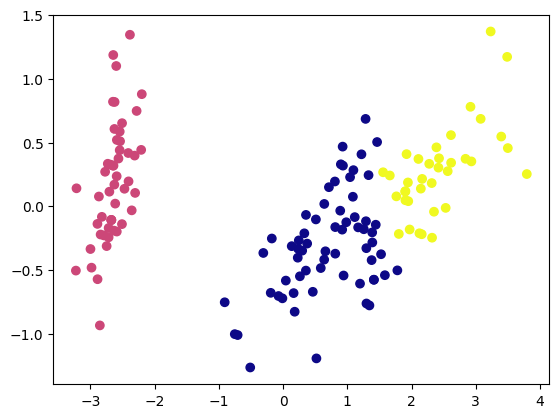

In [17]:
fig = plt.figure()
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=hier_clustering_k3.labels_, cmap='plasma')
plt.show()

Testez d'autres critères de similarité pour fusionner les clusters.

In [18]:
k = 3

for linkage in ['ward', 'average', 'complete', 'single']:
    cl = cluster.AgglomerativeClustering(n_clusters=k, linkage=linkage).fit(X)
    clusters['hier'][linkage] = cl.labels_

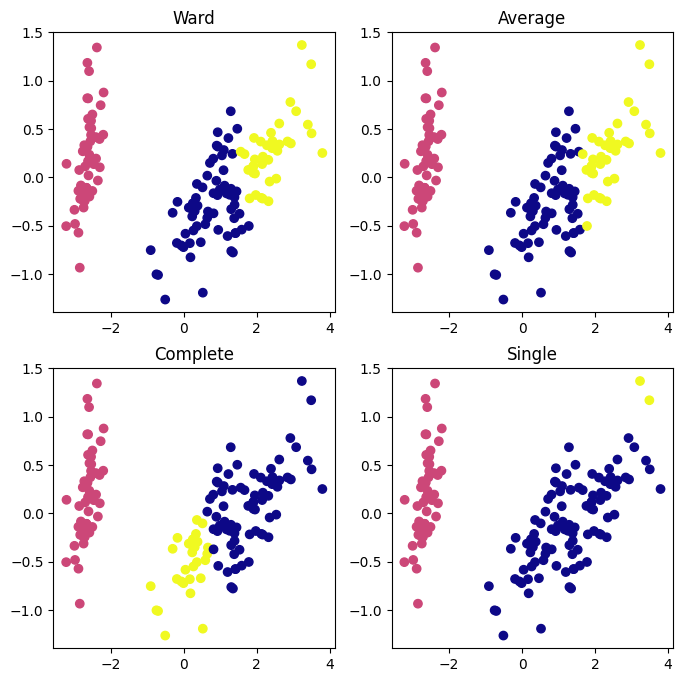

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0, 0].scatter(pca_X[:, 0], pca_X[:, 1], c=clusters['hier']['ward'], cmap='plasma')
ax[0, 1].scatter(pca_X[:, 0], pca_X[:, 1], c=clusters['hier']['average'], cmap='plasma')
ax[1, 0].scatter(pca_X[:, 0], pca_X[:, 1], c=clusters['hier']['complete'], cmap='plasma')
ax[1, 1].scatter(pca_X[:, 0], pca_X[:, 1], c=clusters['hier']['single'], cmap='plasma')

ax[0,0].set_title("Ward")
ax[0,1].set_title("Average")
ax[1,0].set_title("Complete")
ax[1,1].set_title("Single")
plt.show()

### 1.3 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN est un algorithme de clustering basé sur la spacialité qui cherche à trouver des zones à forte densité séparées par des zones à faible densité. La recherche se fait de proche en proche en parcourant une boule de rayon `eps` centrée sur les données. Si aucun voisin n'est inclus dans la boule, alors la zone courante est considérée comme une zone à faible densité, et aucun cluster n'est attribué à la donnée (cluster -1 dans `sklearn.cluster.DBSCAN`).

Utilisez `sklearn.cluster.DBSCAN` pour différentes tailles de voisinage. Que se passe-t-il quand la taille est trop petite ? Trop grande ?

In [20]:
n_clustering = 10
eps = np.linspace(0.1, 2, n_clustering)

for i, e in enumerate(eps): 
    cl_dbscan = cluster.DBSCAN(eps=e).fit(X)
    clusters['dbscan']['eps=' + str(e)] = cl_dbscan.labels_

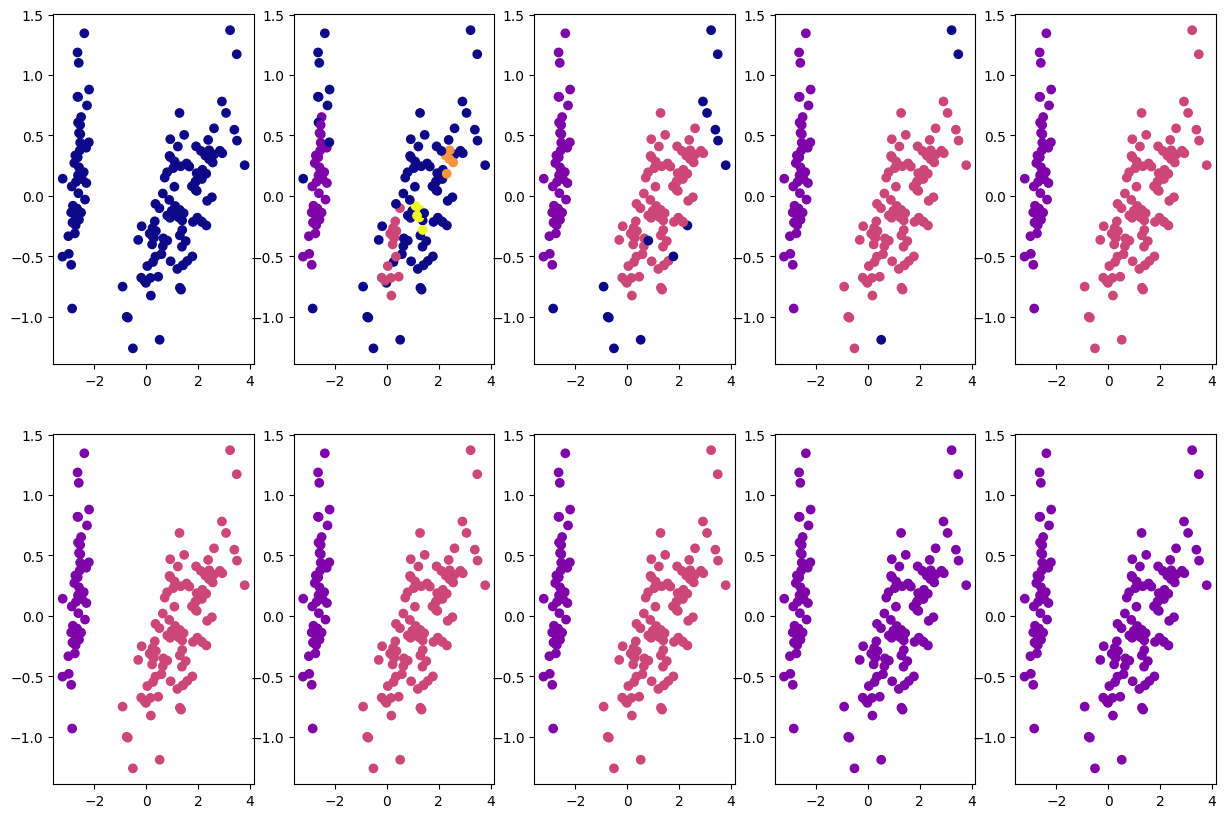

In [27]:
n_rows = 2
n_cols = n_clustering // n_rows

norm = Normalize(vmin=-1, vmax=3)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
for i, dbscan_clusters in enumerate(clusters['dbscan'].values()):
    ax[i // n_cols, i % n_cols].scatter(pca_X[:, 0], pca_X[:, 1], c=dbscan_clusters,  cmap='plasma', norm=norm)
plt.show()

array([[<Axes: title={'center': 'eps=0.1'}>,
        <Axes: title={'center': 'eps=0.3111111111111111'}>,
        <Axes: title={'center': 'eps=0.5222222222222223'}>],
       [<Axes: title={'center': 'eps=0.7333333333333333'}>,
        <Axes: title={'center': 'eps=0.9444444444444444'}>,
        <Axes: title={'center': 'eps=1.1555555555555557'}>],
       [<Axes: title={'center': 'eps=1.3666666666666667'}>,
        <Axes: title={'center': 'eps=1.577777777777778'}>,
        <Axes: title={'center': 'eps=1.788888888888889'}>],
       [<Axes: title={'center': 'eps=2.0'}>, <Axes: >, <Axes: >]],
      dtype=object)

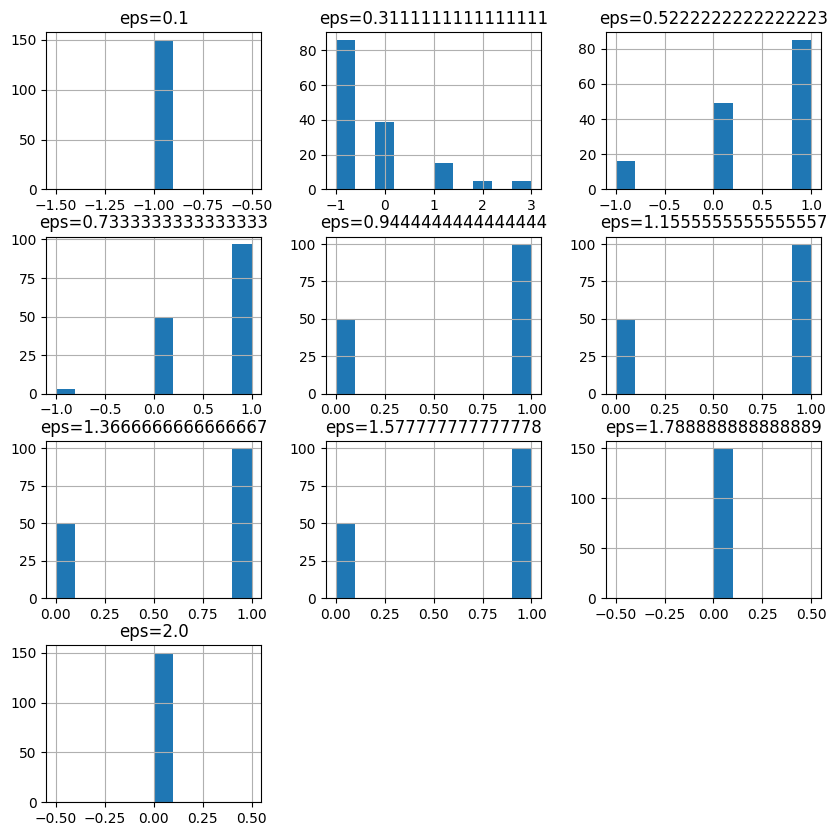

In [180]:
pd.DataFrame(clusters['dbscan']).hist(figsize=(10,10))

## 2. Sélection de modèle 

Comment sélectionner les hyper-paramètres des algorithmes de clustering qui conditionnent le nombre de clusters ? Dans cette partie, nous allons utiliser 4 critères de sélection.

### 2.1 Table de contingence

La table de contingence est un outil statistique simple qui permet de voir rapidement si les individus sont classé dans la même classe entre deux partitions. Deux partitions similaires donneront une matrice diagonale. La table de contingence peut donc être utile pour comparer deux algorithmes de clustering. Néanmoins, sans annotation, elle ne permet pas de sélectionner les hyper-paramètres. 

In [165]:
print("Nb clusters dbscan: ", len(np.unique(clusters))
print("Nb clusters kmeans: ", len(np.unique(clusters_kmeans[:, j])))

clusters_dbscan[:, i]
contingency = metrics.cluster.contingency_matrix(clusters_dbscan[:, i], clusters_kmeans[:,j])
contingency

Nb clusters dbscan:  3
Nb clusters kmeans:  5


array([[ 2,  0,  1,  0,  0],
       [ 0, 50,  0,  0,  0],
       [30,  0, 16, 28, 23]])

In [163]:
clusters_kmeans[:,j].shape

(150,)

### 2.2 Silhouette

Le coefficient de la Silhouette est très utile si la vérité n'est pas connu. Il va mesurer l'homogénéité des groupes. Est ce que les groupes sont assez éloignés des uns des autres ? Est ce que les groupes ne sont pas trop éparpillés ? 

In [47]:

metrics.silhouette_score(X, clust_HAC['ward'], metric = "euclidean")

0.5540972908150553

Pour chaque méthode de clustering, comparer le coefficient de la silhouette afin de sélectionner le modèle avec le meilleur résultat. Enfin sélectionner la meilleure méthode pour nos données. 

In [48]:
clust_kmeans.columns

RangeIndex(start=2, stop=11, step=1)

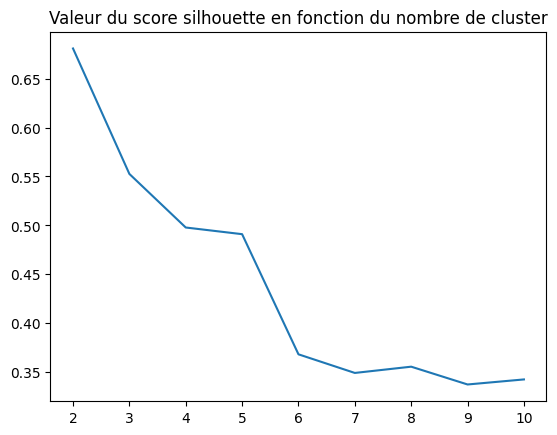

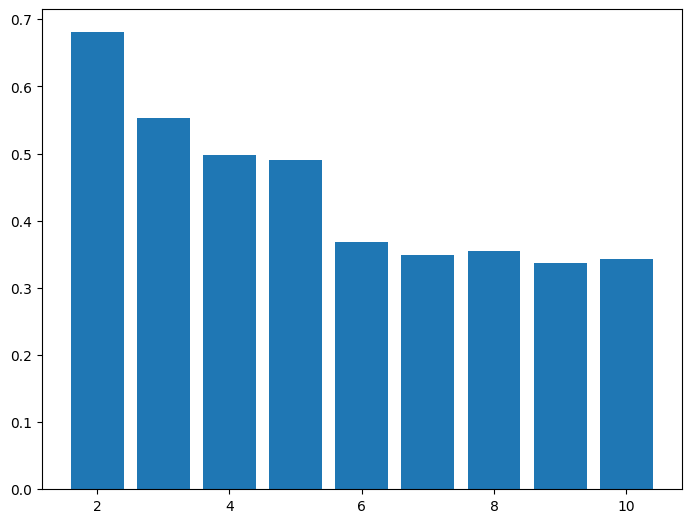

Partition pourlaquelle le kmeans donne un meilleur résultat selon la méthode de la silhouette :  2


In [49]:
silhouette_kmeans = {}
sil_kmeans_plot = []
for k in clust_kmeans.columns: 
    silhouette_kmeans[k] = metrics.silhouette_score(X, clust_kmeans[k], metric = "euclidean")
    sil_kmeans_plot.append(metrics.silhouette_score(X, clust_kmeans[k], metric = "euclidean"))
    
plt.plot(clust_kmeans.columns, sil_kmeans_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_kmeans.columns,sil_kmeans_plot)
plt.show()

print("Partition pourlaquelle le kmeans donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_kmeans, key=silhouette_kmeans.get))

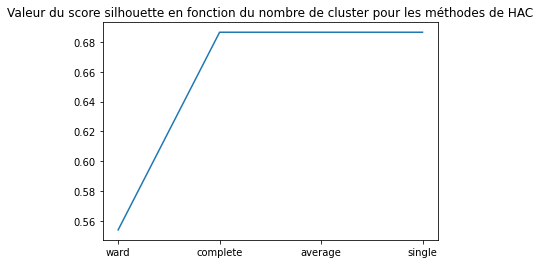

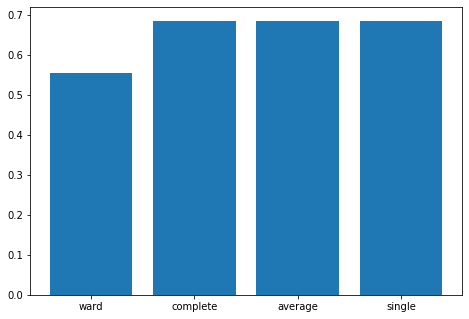

Partition pourlaquelle le HAC donne un meilleur résultat selon la méthode de la silhouette :  complete


In [210]:
silhouette_HAC = {}
sil_HAC_plot = []
for k in clust_HAC.columns: 
    silhouette_HAC[k] = metrics.silhouette_score(X, clust_HAC[k], metric = "euclidean")
    sil_HAC_plot.append(metrics.silhouette_score(X, clust_HAC[k], metric = "euclidean"))
    
plt.plot(clust_HAC.columns, sil_HAC_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de HAC")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_HAC.columns,sil_HAC_plot)
plt.show()

print("Partition pourlaquelle le HAC donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_HAC, key=silhouette_HAC.get))

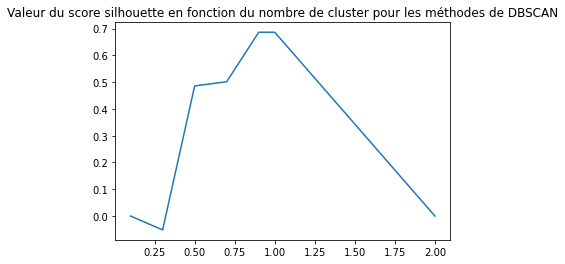

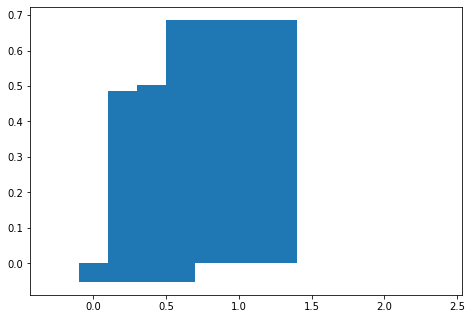

Partition pourlaquelle le DBSCAN donne un meilleur résultat selon la méthode de la silhouette :  0.9


In [211]:
silhouette_DBSCAN = {}
sil_DBSCAN_plot = []
for k in clust_DBSCAN.columns: 
    if (len(np.unique(clust_DBSCAN[k])) == 1): 
        silhouette_DBSCAN[k] = 0
        sil_DBSCAN_plot.append(0)
    else : 
        silhouette_DBSCAN[k] = metrics.silhouette_score(X, clust_DBSCAN[k], metric = "euclidean")
        sil_DBSCAN_plot.append(metrics.silhouette_score(X, clust_DBSCAN[k], metric = "euclidean"))
    
plt.plot(clust_DBSCAN.columns, sil_DBSCAN_plot)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust_DBSCAN.columns,sil_DBSCAN_plot)
plt.show()

print("Partition pourlaquelle le DBSCAN donne un meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette_DBSCAN, key=silhouette_DBSCAN.get))

In [212]:
["DBSCAN " + str(s) for s in clust_DBSCAN.columns]

['DBSCAN 0.1',
 'DBSCAN 0.3',
 'DBSCAN 0.5',
 'DBSCAN 0.7',
 'DBSCAN 0.9',
 'DBSCAN 1.0',
 'DBSCAN 2.0']

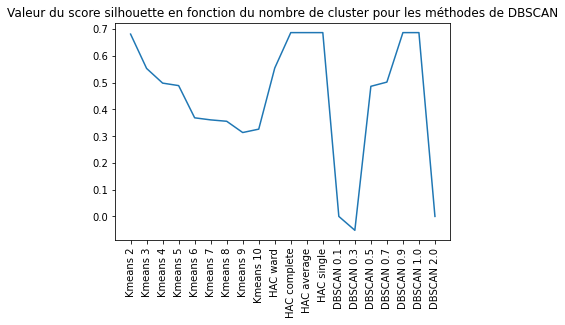

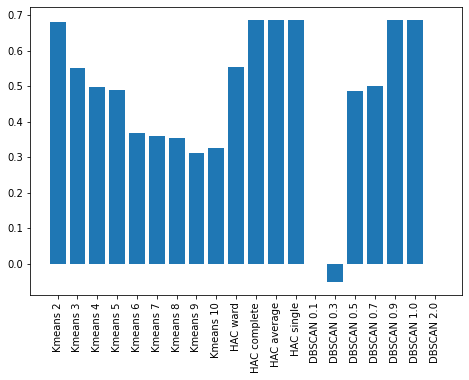

Meilleur résultat selon la méthode de la silhouette :  HAC complete


In [213]:


silhouette = {}
sil_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        silhouette[k] = 0
        sil_plot.append(0)
    else : 
        silhouette[k] = metrics.silhouette_score(X, clust[k], metric = "euclidean")
        sil_plot.append(metrics.silhouette_score(X, clust[k], metric = "euclidean"))
    
plt.plot(clust.columns, sil_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,sil_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(silhouette, key=silhouette.get))

### 2.3 V mesure

La mesure V demande de connaitre la vérité que nous cherchons à approcher. La mesure V est fonction de deux autres mesures: 

- Homogénéité : chaque cluster ne contient que des individus du même type (au sens de la vérité)
- Completeness : tous les membres d'un même type sont affectés au même clusters. 

On voit que ces deux mesures vont dans deux sens différents mais sont très complémentaires afin d'avoir un bon clustering (et retrouver la vérité). 

La mesure V est mesuré telque : $$v = \frac{(1+\beta) \times \text{homogeneity} \times \text{completness}}{\beta (\text{homogeneity}+\text{completness})}$$

1) Trouver le clustering qui s'approche le plus de la vérité. 

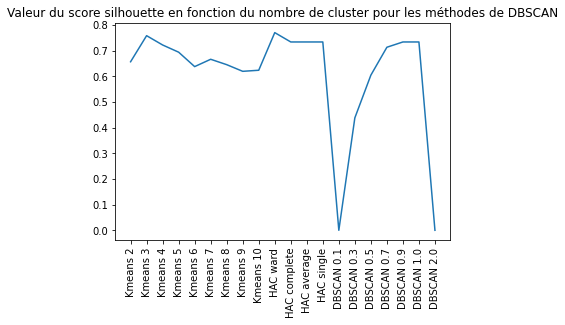

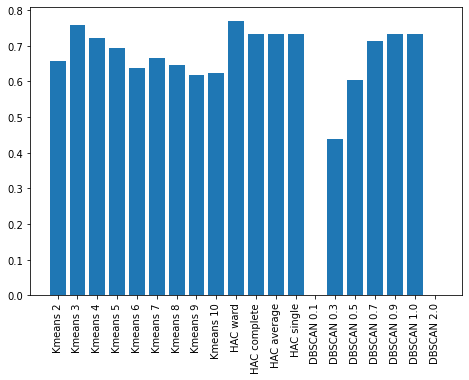

Meilleur résultat selon la méthode de la silhouette :  HAC ward


In [219]:
Vmesure = {}
Vmesure_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        Vmesure[k] = 0
        Vmesure_plot.append(0)
    else : 
        Vmesure[k] = metrics.v_measure_score(truth["species"], clust[k])
        Vmesure_plot.append(metrics.v_measure_score(truth["species"], clust[k]))
    
plt.plot(clust.columns, Vmesure_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,Vmesure_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(Vmesure, key=Vmesure.get))

In [218]:
truth["species"]

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: species, Length: 150, dtype: object

### 2.4 Adjusted Rand Index

L'index de Rand est un score qui permet de mesurer la similitude entre deux partitions en comparant les paires de points deux à deux en mesurant si ces deux points sont classés ensemble ou non dans les deux partitions. La formule simplifié est : 
Soit a le nombre de paires d'individus regroupés dans les deux paritions et b le nombre d'individus qui ne sont regroupé ni dans la partition 1 ni dans la partition 2. Soit $\binom{n}{2}$ le nombre de paires d'individus totale possibles. 
L'indice de Rand est $$ RI = \frac{a+b}{\binom{n}{2}}$$

La formule ajustée permet de mieux comparer des partitions avec des nombres de classe différentes: 
$$Adjusted RI = \frac{RI - \mathbb{E}[RI]}{ \max RI - \mathbb{E}[RI]} $$
avec $\mathbb{E}[RI]$ l'espérance de l'indice de Rand. 

Cet indice s'interprète comme suivant : 
Plus la valeur est proche de 1 plus les partitions sont similaires. Un ARI de 1 signifie que les partitions sont strictement les mêmes. Un ARI de 0 signifie que les deux partitions sont "indépendantes" (ici à ne pas prendre comme le sens strictement mathématique de l'indépendance). 


Un avantage de cette métrique est que les labels des clusterings peuvent être strictement différents, le score sera toujours le même. Pourquoi est ce interessant ? 

Mesurer le ARI de chaque partition avec la vérité (c'est à dire les epèces d'iris) et donner la meilleures partitions. 

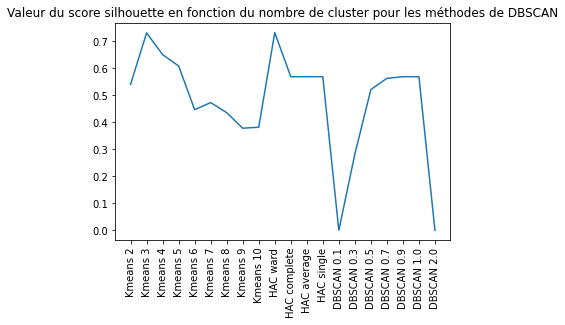

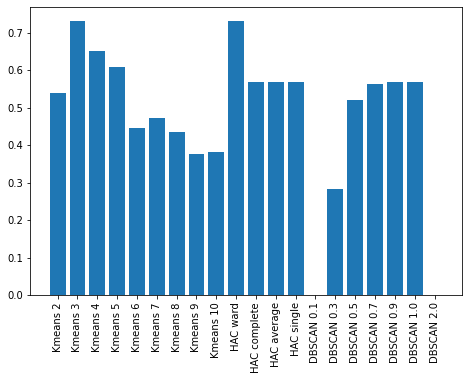

Meilleur résultat selon la méthode de la silhouette :  HAC ward


In [220]:
ARI = {}
ARI_plot = []
for k in clust.columns: 
    if (len(np.unique(clust[k])) == 1): 
        ARI[k] = 0
        ARI_plot.append(0)
    else : 
        ARI[k] = metrics.adjusted_rand_score(truth["species"], clust[k])
        ARI_plot.append(metrics.adjusted_rand_score(truth["species"], clust[k]))
    
plt.plot(clust.columns, ARI_plot)
plt.xticks(rotation=90)
plt.title("Valeur du score silhouette en fonction du nombre de cluster pour les méthodes de DBSCAN")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(clust.columns,ARI_plot)
plt.xticks(rotation=90)
plt.show()

print("Meilleur résultat selon la méthode de la silhouette : ", 
     max(ARI, key=ARI.get))

## Conclusion 

Quelles sont vos conclusions ? 

Quelles distinctions peut on voir entre les clusterings ?
Est ce que les méthodes de sélections de modèles donnent comme meilleur résultat le même clustering ? 